In [290]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

df = pd.read_csv('salos.csv')

Оптимизируем способ хранения данных при помощи изменения типов и оптимизации памяти

In [291]:
def optimize_dataframe(df):
  # iterate over all of the columns in the dataframe
  for col in df.columns:
    # get the current data type of the column
    dtype = df[col].dtype
    
    # if the data type is object (e.g. string), try to convert it to a numeric data type
    if dtype == 'object':
      try:
        df[col] = pd.to_numeric(df[col])
      except ValueError:
        pass
        
    # if the data type is numeric, find the smallest integer data type that can accommodate the maximum value in the column
    elif np.issubdtype(dtype, np.number):
      max_val = df[col].max()
      
      if max_val < np.iinfo(np.int8).max:
        df[col] = df[col].astype(np.int8)
      elif max_val < np.iinfo(np.int16).max:
        df[col] = df[col].astype(np.int16)
      elif max_val < np.iinfo(np.int32).max:
        df[col] = df[col].astype(np.int32)
      else:
        df[col] = df[col].astype(np.int64)
        
  return df
df = optimize_dataframe(df)

In [292]:
df.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Date,Time,Payment,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74,7,1/5/2019,13:08,Ewallet,4,26,9
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15,5,3/8/2019,10:29,Cash,4,3,9
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46,7,3/3/2019,13:23,Credit card,4,16,7
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58,8,1/27/2019,20:33,Ewallet,4,23,8
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86,7,2/8/2019,10:37,Ewallet,4,30,5


Проверим на наличие дубликатов данных:

In [293]:
df.isna().sum()

Invoice ID                 0
Branch                     0
City                       0
Customer type              0
Gender                     0
Product line               0
Unit price                 0
Quantity                   0
Date                       0
Time                       0
Payment                    0
gross margin percentage    0
gross income               0
Rating                     0
dtype: int64

Проверим, оптимальны ли типы датафрейма

In [294]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Invoice ID               1000 non-null   object
 1   Branch                   1000 non-null   object
 2   City                     1000 non-null   object
 3   Customer type            1000 non-null   object
 4   Gender                   1000 non-null   object
 5   Product line             1000 non-null   object
 6   Unit price               1000 non-null   int8  
 7   Quantity                 1000 non-null   int8  
 8   Date                     1000 non-null   object
 9   Time                     1000 non-null   object
 10  Payment                  1000 non-null   object
 11  gross margin percentage  1000 non-null   int8  
 12  gross income             1000 non-null   int8  
 13  Rating                   1000 non-null   int8  
dtypes: int8(5), object(9)
memory usage: 574.4

Вывод: память используется оптимально, повторений нет

## Обработка данных

Первым делом построим матрицу корреляций чтобы увидеть потенциальные зависимости и избыточные данные:

In [295]:
def remove_redundant_columns(df: pd.DataFrame, threshold: float = 0.9) -> pd.DataFrame:
    corr_matrix = df.corr()

    # Select the correlated columns
    correlated_columns = set()
    for col in corr_matrix.columns:
        correlated_columns.update(set(corr_matrix.loc[abs(corr_matrix[col]) > threshold].index))

    # Keep only one of the correlated columns
    correlated_columns = list(correlated_columns)
    if len(correlated_columns) > 1:
        correlated_columns = correlated_columns[1:]
    # Drop the duplicate and correlated columns
    df = df.drop(columns=correlated_columns)
    return df
#df = remove_redundant_columns(df)


In [296]:
def write_df_to_csv(df: pd.DataFrame, file_path: str) -> None:
    df.to_csv(file_path, index=False)
df.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Date,Time,Payment,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74,7,1/5/2019,13:08,Ewallet,4,26,9
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15,5,3/8/2019,10:29,Cash,4,3,9
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46,7,3/3/2019,13:23,Credit card,4,16,7
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58,8,1/27/2019,20:33,Ewallet,4,23,8
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86,7,2/8/2019,10:37,Ewallet,4,30,5


In [297]:
corr_matrix = df.corr()

# Print the correlation matrix
print(corr_matrix)



                         Unit price  Quantity  gross margin percentage  \
Unit price                 1.000000  0.010769                      NaN   
Quantity                   0.010769  1.000000                      NaN   
gross margin percentage         NaN       NaN                      NaN   
gross income               0.632618  0.706176                      NaN   
Rating                    -0.008848 -0.009099                      NaN   

                         gross income    Rating  
Unit price                   0.632618 -0.008848  
Quantity                     0.706176 -0.009099  
gross margin percentage           NaN       NaN  
gross income                 1.000000 -0.030846  
Rating                      -0.030846  1.000000  


C:\Users\Ponamarev\AppData\Local\Temp\ipykernel_6540\2336445559.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


### Гипотезы:
1. Доход магазина имеет прямую корреляцию со средней стоимостью одного товара (то есть продавать более дорогие товары выгоднее)
2. Большинство оплат производится при помощи электронных кошельков
3. По пятницам люди тратят больше денег, чем в другие дни недели
4. Еда - самая популярная категория продуктов

Проверим 1 гипотезу

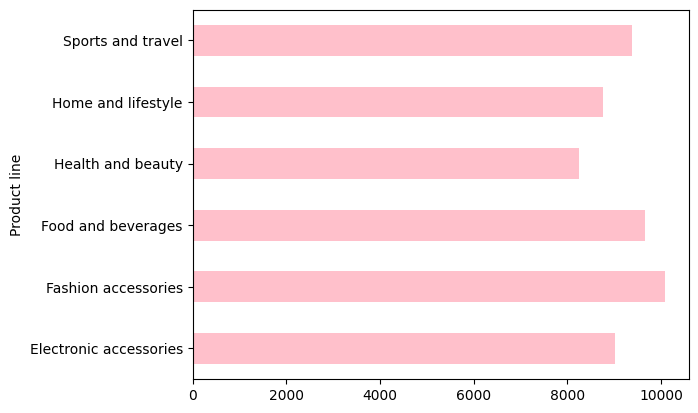

In [298]:
def plot_sums_by_category(df):
    # Group the DataFrame by the "Product line" field
    grouped = df.groupby('Product line')

    # Calculate the sums of the "Unit price" field for each group
    sums = grouped['Unit price'].sum()

    # Plot a red histogram of the sums
    sums.plot.barh(color='pink')
    plt.show()

plot_sums_by_category(df)

Как мы можем наблюдать, на модные аксесуары люди тратят даже больше денег

Попробуем выяснить, в какой категории находятся самые дорогие товары?

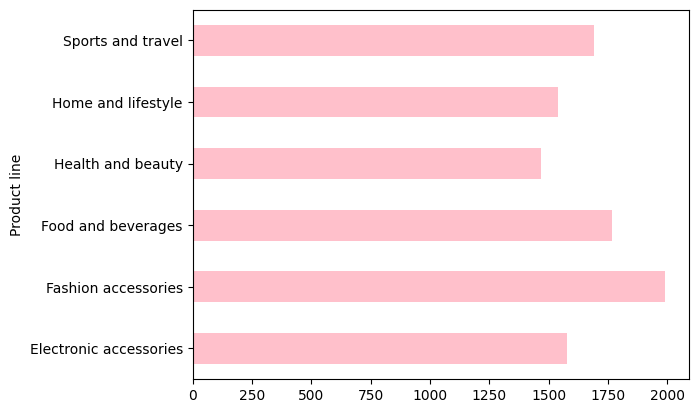

In [299]:
import pandas as pd

def plot_sums_by_category_adv(df):
    # Group the DataFrame by the "Product line" field
    grouped = df.groupby('Product line')

    # Calculate the sums of the "Unit price" field for each group
    sums = grouped['Unit price'].sum()

    # Calculate the average value of the "Quantity" field for each group
    avg_quantity = grouped['Quantity'].mean()

    # Divide the sums by the average quantity
    normalized_sums = sums / avg_quantity

    # Plot a horizontal bar chart of the normalized sums
    normalized_sums.plot.barh(color='pink')

plot_sums_by_category_adv(df)

Модные аксесуары тут тоже впереди, гипотеза опровергнута: на еду люди тратят меньше денег, чем на одежду и моду

Проверим следующую гипотезу: большинство оплат производится с помощью электронных кошельков

([<matplotlib.patches.Wedge at 0x1fc39d9b350>,
 [Text(0.5177742897621297, 0.9705203680816401, 'Cash'),
  Text(-1.099994571861817, 0.003455701743252279, 'Credit card'),
  Text(0.5147227993273711, -0.9721421911698901, 'Ewallet')])

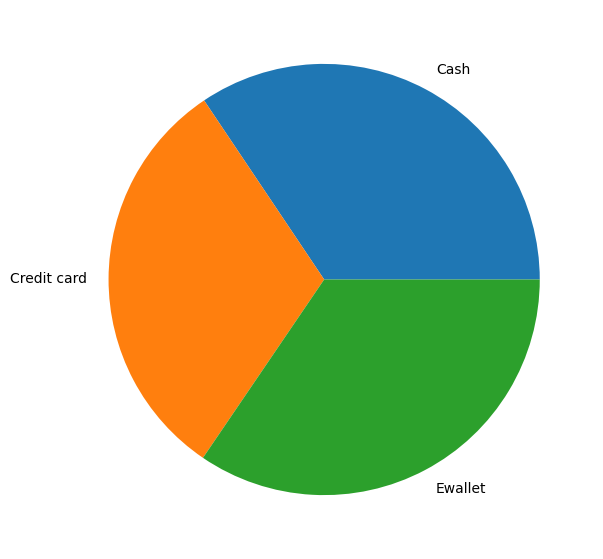

In [300]:
topResign = df.groupby('Payment')['Payment'].count()
resigns = topResign.index
plt.figure(figsize=(20, 7))
plt.pie(x=topResign, labels=resigns)

Электронный кошелек с небольшим перевесом лидирует. Гипотеза подтверждается.

Проверим третью гипотезу - что в пятницу люди тратят больше, чем в остальные дни недели

In [301]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# create a new column with the day of the week for each date
df['day_of_week'] = df['Date'].dt.day_name()

print(df['day_of_week'])

0      Saturday
1        Friday
2        Sunday
3        Sunday
4        Friday
         ...   
995     Tuesday
996    Saturday
997    Saturday
998      Friday
999      Monday
Name: day_of_week, Length: 1000, dtype: object


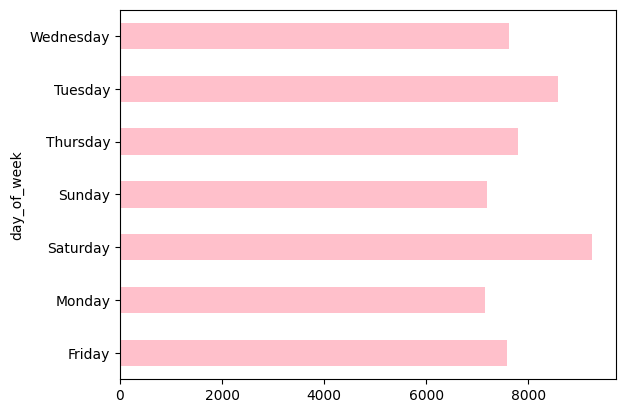

In [302]:
def plot_sums_by_day(df):
    # Group the DataFrame by the "Product line" field
    grouped = df.groupby('day_of_week')

    # Calculate the sums of the "Unit price" field for each group
    sums = grouped['Unit price'].sum()

    # Plot a red histogram of the sums
    sums.plot.barh(color='pink')
    plt.show()

plot_sums_by_day(df)

Гипотеза не подтвердилась, наибольшее количество денег люди тратят в субботу.

In [303]:
from sklearn.linear_model import LinearRegression

# calculate the 'Unit price divided by Quantity' column
df['Unit price divided by Quantity'] = df['Unit price']
# define the X and y variables for the linear regression
X = df['Unit price divided by Quantity'].values.reshape(-1, 1)
y = df['gross income'].values.reshape(-1, 1)

# fit a linear regression model
model = LinearRegression()
model.fit(X, y)

# calculate the predicted values and the R^2 score
y_pred = model.predict(X)
r2 = model.score(X, y)

# print the results
print('Predicted values:', y_pred)
print('R^2 score:', r2)


Predicted values: [[20.13215097]
 [ 3.62220209]
 [12.29692099]
 [15.65487669]
 [23.49010667]
 [23.21027703]
 [18.45317311]
 [19.85232132]
 [ 9.49862457]
 [14.53555813]
 [ 3.34237245]
 [ 6.42049851]
 [12.29692099]
 [11.45743206]
 [19.29266204]
 [25.44891416]
 [18.45317311]
 [19.57249168]
 [14.53555813]
 [10.61794314]
 [23.49010667]
 [23.76993631]
 [ 8.65913564]
 [ 8.93896529]
 [24.04976595]
 [13.97589884]
 [ 8.65913564]
 [23.76993631]
 [24.04976595]
 [ 6.14066887]
 [25.72874381]
 [21.25146953]
 [22.65061774]
 [26.28840309]
 [27.12789202]
 [18.45317311]
 [16.77419526]
 [16.21453598]
 [14.53555813]
 [ 7.81964672]
 [23.49010667]
 [15.09521741]
 [18.73300276]
 [26.84806237]
 [ 3.62220209]
 [25.44891416]
 [15.09521741]
 [ 5.0213503 ]
 [ 4.46169101]
 [22.3707881 ]
 [24.88925488]
 [11.73726171]
 [ 4.18186137]
 [ 3.62220209]
 [ 3.90203173]
 [23.21027703]
 [11.73726171]
 [24.3295956 ]
 [19.57249168]
 [ 7.81964672]
 [ 6.14066887]
 [14.81538777]
 [14.81538777]
 [ 3.62220209]
 [20.41198061]
 [ 3.62

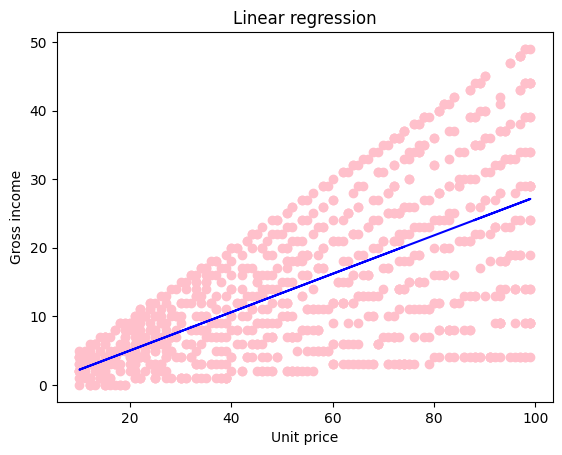

In [305]:
plt.scatter(X, y, color='pink')
plt.plot(X, y_pred, color='blue')

# add labels and title to the plot
plt.xlabel('Unit price')
plt.ylabel('Gross income')
plt.title('Linear regression')

# show the plot
plt.show()

В целом можно говорить о том, что с ростом цены товара расет и прибыль магазина